# Envelopes Strategy

### Example of 100 candles of 15 min

In [336]:
#!pip install oandapyV20

In [337]:
#!pip install zulu

In [338]:
#!pip install mpl_finance

In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os

pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
ID = '1XX-XXX-XXXXXXX-XX1'
token = '49XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX74'

In [3]:
client = oandapyV20.API(access_token=token)

In [4]:
params = {
          "count": 100,
          "granularity": "M15"}

In [5]:
r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                   params=params)

In [6]:
rv = client.request(r)

In [7]:
dat = []
for oo in r.response['candles']:
    dat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])

In [8]:
df = pd.DataFrame(dat)
df.columns = ['Time', 'Open', 'High', 'Low', 'Close']
df["Time"] = pd.to_datetime(df['Time'])
df['Time'] = df['Time'].apply(mpl_dates.date2num)
df = df.astype(float)
#df = df.set_index('Time')
df.head()

,Time,Open,High,Low,Close
0,737510.0833,1.0907,1.0911,1.0903,1.0904
1,737510.0938,1.0904,1.0906,1.0896,1.0898
2,737510.1042,1.0897,1.0902,1.0892,1.0899
3,737510.1146,1.0899,1.0915,1.0899,1.0915
4,737510.1250,1.0915,1.0919,1.0909,1.0912


In [9]:
plt.style.use('ggplot')

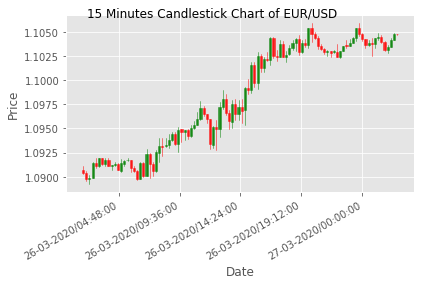

In [10]:
# Creating Subplots
fig, ax = plt.subplots()

candlestick_ohlc(ax, df.values, width=0.007, colorup='green', colordown='red', alpha=0.8)

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('15 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

## Envelope strategy on EURUSD

In [11]:
# To do only to start the dataset
params = {
        "from": "2010-04-01T00:00:00Z",
        "granularity": "M15"}

r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                   params=params)

rv = client.request(r)

dat = []
for oo in r.response['candles']:
    dat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
eurusd = pd.DataFrame(dat)
eurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
eurusd["Time"] = pd.to_datetime(eurusd['Time'])
Date = eurusd['Time']
eurusd['Time'] = eurusd['Time'].apply(mpl_dates.date2num)
eurusd = eurusd.astype(float)
eurusd.head()

,Time,Open,High,Low,Close
0,733863.0000,1.3527,1.3546,1.3523,1.3541
1,733863.0104,1.3541,1.3562,1.3538,1.3552
2,733863.0208,1.3552,1.3554,1.3544,1.3546
3,733863.0312,1.3546,1.3547,1.3526,1.3530
4,733863.0417,1.3530,1.3530,1.3518,1.3518


In [12]:
# Loop to feed the dataset with new rates
while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 3:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=15)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M15"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)

In [13]:
#First and Last Day of the dataset
print(eurusd.shape)
print(Date.iloc[0])
print(Date.iloc[-1])
print(eurusd.head(5))

(249500, 5)
2010-04-01 00:00:00
2020-03-04 03:00:00
         Time   Open   High    Low  Close
0 733863.0000 1.3527 1.3546 1.3523 1.3541
1 733863.0104 1.3541 1.3562 1.3538 1.3552
2 733863.0208 1.3552 1.3554 1.3544 1.3546
3 733863.0312 1.3546 1.3547 1.3526 1.3530
4 733863.0417 1.3530 1.3530 1.3518 1.3518


### Definition of the Envelopes

In [14]:
def ENV(rates, period, deviation):
    UL=[]
    ML=[]
    LL=[]
    
    SMA = eurusd['Close'].rolling(period).mean()
    
    for eachsma in SMA:
        uls = eachsma + (eachsma*deviation)
        lls = eachsma - (eachsma*deviation)
        mls = eachsma
    
        UL.append(uls)
        LL.append(lls)
        ML.append(mls)
        
    return period, UL, ML, LL  

In [15]:
period, ul, ml, ll = ENV(eurusd, 40, 0.007)
eurusd["ul"] = ul
eurusd["ml"] = ml
eurusd["ll"] = ll

In [16]:
eurusd.index = range(eurusd.shape[0])
eurusd = eurusd.drop(eurusd.index[0:period])
eurusd.index = range(eurusd.shape[0])

In [17]:
eurusd.head(5)

,Time,Open,High,Low,Close,ul,ml,ll
0,733863.4167,1.3504,1.3506,1.3501,1.3506,1.3601,1.3506,1.3412
1,733863.4271,1.3506,1.3512,1.3501,1.3501,1.3599,1.3505,1.3410
2,733863.4375,1.3502,1.3502,1.3494,1.3495,1.3598,1.3504,1.3409
3,733863.4479,1.3495,1.3498,1.3492,1.3497,1.3597,1.3503,1.3408
4,733863.4583,1.3497,1.3497,1.3490,1.3497,1.3597,1.3502,1.3408


In [18]:
#Export the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd15minEnvelopes.csv')

In [19]:
count = 0
for i in range(0,eurusd.shape[0]):
    if eurusd.Low[i] < eurusd.ll[i] or eurusd.High[i] > eurusd.ul[i]:
        count=count+1
        
print(count)
        

3478


In [20]:
plt.style.use('ggplot')

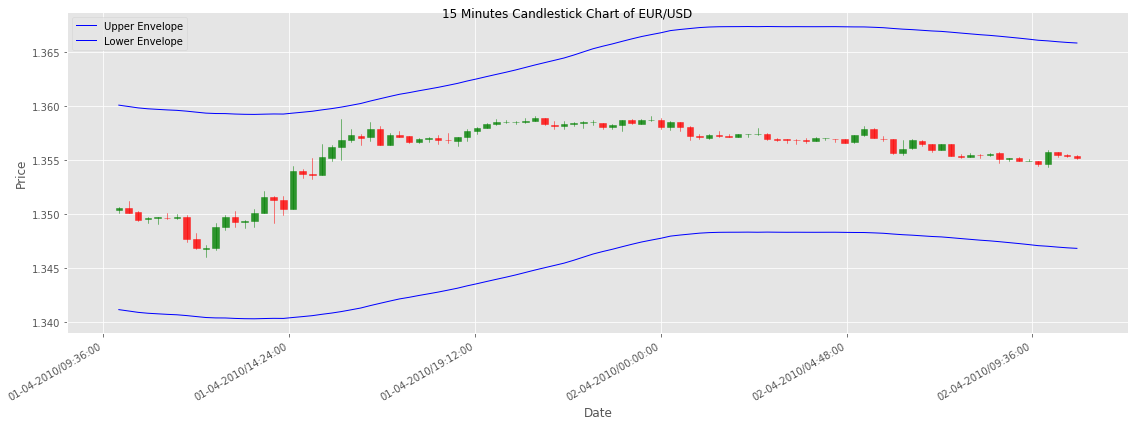

In [44]:
# Creating Subplots
fig, ax = plt.subplots(figsize = (16,6))

candlestick_ohlc(ax, eurusd.iloc[range(100), range(5)].values, width=0.007, colorup='green', colordown='red', alpha=0.8)
ax.plot(eurusd['Time'][:100], eurusd["ul"][:100], color = 'blue', linewidth = 1, label='Upper Envelope')
ax.plot(eurusd['Time'][:100], eurusd["ll"][:100], color = 'blue', linewidth = 1, label='Lower Envelope')
leg = ax.legend();

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('15 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()